# Setup

In [506]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [524]:
import itertools

from environment import TrafficModel, Car
from util.network import create_braess_network, create_double_braess_network, create_cars, build_network
from util.analysis import draw_network

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import networkx as nx
from tqdm import tqdm, trange
import math
import matplotlib.ticker as mtick
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [508]:
def create_multiple_braess_network(k=0, capacity=100):
    network = nx.DiGraph(
        [('S0', 'A'), ('S0', 'B'), ('A', 'B'), ('A', 'T0'), ('B', 'T0')]
        + [(f'S{i}', f'S{i-1}') for i in range(1, k + 1)]
        + [(f'S{i}', 'B') for i in range(1, k + 1)]
        + [(f'S{i-1}', f'T{i}') for i in range(1, k + 1)]
        + [('B', f'T{i}') for i in range(1, k + 1)]
    )

    nx.set_node_attributes(
        network,
        {
            **{'A': (3 * math.cos(-1 * 2 * math.pi / (2*k+4)), 3 * math.sin(-1 * 2 * math.pi / (2*k+4))), 'B': (0, 0)},
            **{f'S{i}': (3 * math.cos((2*i+1) * 2 * math.pi / (2*k+4)), 3 * math.sin((2*i+1) * 2 * math.pi / (2*k+4))) for i in range(0, k + 1)},
            **{f'T{i}': (1.5 * math.cos(2*i * 2 * math.pi / (2*k+4)), 1.5 * math.sin(2*i * 2 * math.pi / (2*k+4))) for i in range(0, k + 1)}
        },
        "position",
    )

    nx.set_edge_attributes(
        network,
        {
            ('S0', 'A'): (2, 6, capacity, 1), ('S0', 'B'): (10, 0, 1, 1), ('A', 'B'): (1, 0, 1, 1), ('A', 'T0'): (10, 0, 1, 1), ('B', 'T0'): (2, 6, capacity, 1),
            **{(f'S{i}', f'S{i-1}'): (2, 6, capacity, 1) for i in range(1, k + 1)},
            **{(f'S{i}', 'B'): (11 + 2*i, 0, 1, 1) for i in range(1, k + 1)},
            **{(f'S{i-1}', f'T{i}'): (11 + 2*i, 0, 1, 1) for i in range(1, k + 1)},
            **{('B', f'T{i}'): (2, 6, capacity, 1) for i in range(1, k + 1)}
        },
        "latency_params",
    )

    return build_network(network)

In [509]:
def plot_results(car_stats, *, rolling=10):
    stats = car_stats.set_index('step')

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    pd.DataFrame({route: stats['route'] == route for route in stats['route'].unique()}).rolling(rolling).mean().plot(ax=ax1)
    ax1.legend(stats['route'].unique())
    ax1.set_title('Fraction of cars per route')

    pd.DataFrame({'Travel time': stats['travel_time'], 'Total cost': stats['total_cost']}).rolling(rolling).mean().plot(ax=ax2)
    ax2.set_title('Social welfare')

In [510]:
def change_value_of_money(cars, possible_values, *, seed=42):
    rng = np.random.default_rng(seed)

    for car in cars.values():
        car.value_of_money = rng.choice(possible_values)

In [511]:
def compute_regression(data):
    lrr = LinearRegression()
    est = lrr.fit(data.index.to_numpy().reshape(-1, 1), data.to_numpy())
    error = mean_squared_error(data.to_numpy(), lrr.predict(data.index.to_numpy().reshape(-1, 1)))

    return est.coef_[0], est.intercept_, error

# Sanity check

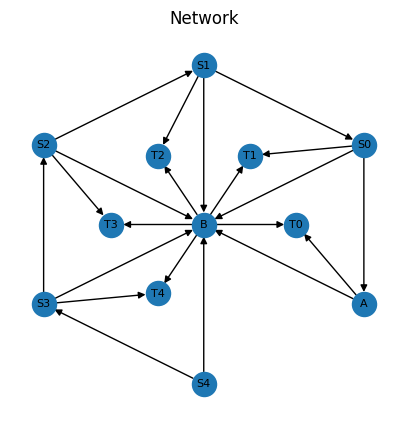

In [569]:
draw_network(create_multiple_braess_network(k=4, capacity=capacity))

In [292]:
{(v, w): p for v, w, p in network.edges(data='latency_params') if v != w}

{('S0', 'A'): (2, 6, 20, 1),
 ('S0', 'B'): (10, 0, 1, 1),
 ('S0', 'T1'): (14, 0, 1, 1),
 ('A', 'B'): (1, 0, 1, 1),
 ('A', 'T0'): (10, 0, 1, 1),
 ('B', 'T0'): (2, 6, 20, 1),
 ('B', 'T1'): (2, 6, 20, 1),
 ('B', 'T2'): (2, 6, 20, 1),
 ('B', 'T3'): (2, 6, 20, 1),
 ('S1', 'S0'): (2, 6, 20, 1),
 ('S1', 'B'): (14, 0, 1, 1),
 ('S1', 'T2'): (18, 0, 1, 1),
 ('S2', 'S1'): (2, 6, 20, 1),
 ('S2', 'B'): (18, 0, 1, 1),
 ('S2', 'T3'): (22, 0, 1, 1),
 ('S3', 'S2'): (2, 6, 20, 1),
 ('S3', 'B'): (22, 0, 1, 1)}

In [329]:
k = 5
capacity = 20
demand = 5

number_of_steps = 1_000
car_counts = {(f'S{demand}', f'T{demand}'): 50}

rolling = 100

Unrestricted mean travel time: -29.951917224589167


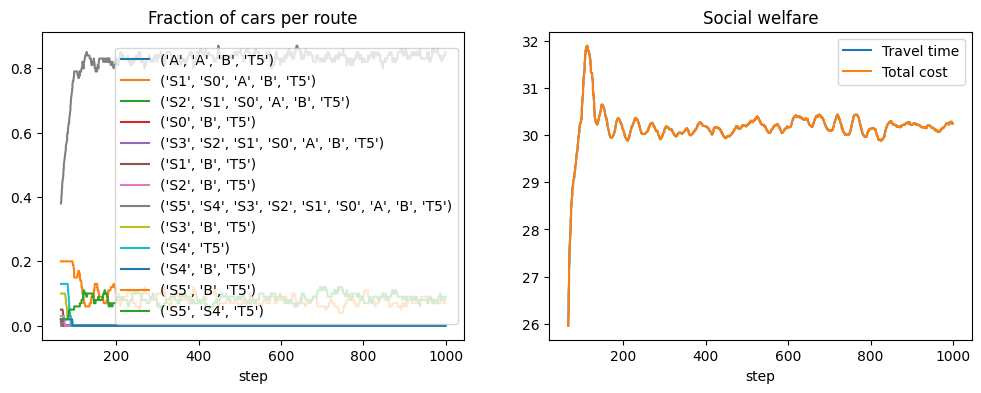

In [330]:
# Unrestricted
network = create_multiple_braess_network(k=k, capacity=capacity)
model = TrafficModel(network, create_cars(network, car_counts=car_counts))
step_stats_unrestricted, car_stats_unrestricted = model.run_sequentially(number_of_steps, show_progress=False)
print(f'Unrestricted mean travel time: {(-car_stats_unrestricted["travel_time"]).mean()}')

plot_results(car_stats_unrestricted, rolling=rolling)

Restricted mean travel time: -28.15374841168996


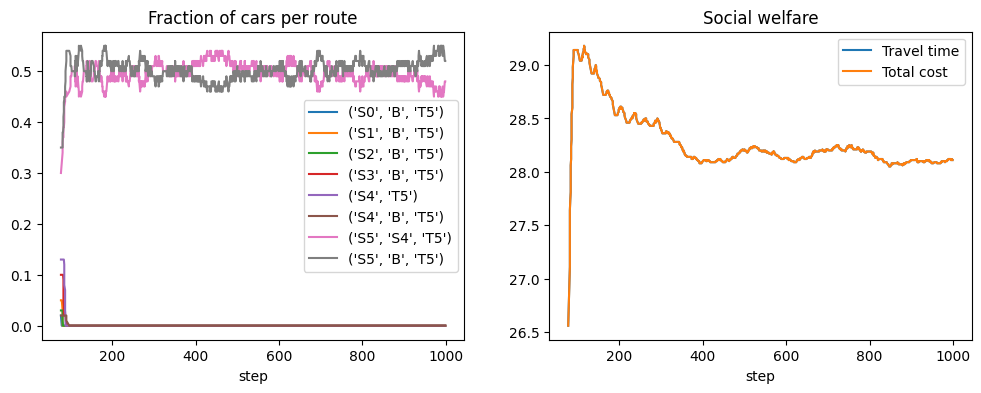

In [331]:
# Restricted
network = create_multiple_braess_network(k=k, capacity=capacity)
model = TrafficModel(network, create_cars(network, car_counts=car_counts))

model.set_edge_restriction(('A', 'B'), False)
for i in range(1, min(demand, k) + 1):
    model.set_edge_restriction((f'S{i-1}', 'B'), False)

step_stats_restricted, car_stats_restricted = model.run_sequentially(number_of_steps, show_progress=False)
print(f'Restricted mean travel time: {(-car_stats_restricted["travel_time"]).mean()}')

plot_results(car_stats_restricted, rolling=rolling)

In [332]:
step_stats_restricted['latency'][[('S1', 'S0'), ('S1', 'B'), ('S0', 'B'), ('S0', 'T1'), ('B', 'T1')]].describe()

,"(S1, S0)","(S1, B)","(S0, B)","(S0, T1)","(B, T1)"
count,1000.000000,1000.0,1000.0,1000.0,1000.0
mean,2.000900,13.0,10.0,13.0,2.0
std,0.016415,0.0,0.0,0.0,0.0
min,2.000000,13.0,10.0,13.0,2.0
25%,2.000000,13.0,10.0,13.0,2.0
50%,2.000000,13.0,10.0,13.0,2.0
75%,2.000000,13.0,10.0,13.0,2.0
max,2.300000,13.0,10.0,13.0,2.0


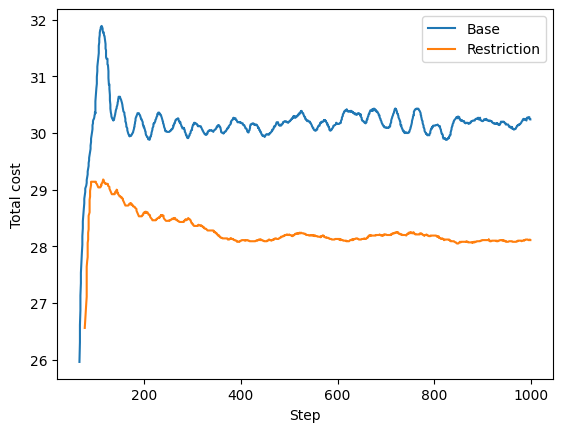

In [333]:
cutoff = 0

fig, ax = plt.subplots(1, 1)

ax.plot(car_stats_unrestricted[car_stats_unrestricted['step'] >= cutoff].set_index('step')['travel_time'].rolling(rolling).mean(), label='Base')
ax.plot(car_stats_restricted[car_stats_restricted['step'] >= cutoff].set_index('step')['travel_time'].rolling(rolling).mean(), label='Restriction')

ax.set_xlabel('Step')
ax.set_ylabel('Total cost')
ax.legend()

# Experiment

## Different demands on same graph

In [552]:
BASE_COLOR = 'aqua'
RESTRICTION_COLOR = 'coral'
TOLLING_COLOR = 'darkred'

In [522]:
def analyze_fairness(car_stats, cutoff=0):
    data = car_stats[car_stats['step'] >= cutoff].groupby('value_of_money')['travel_time'].mean()
    slope, intercept, error = compute_regression(data)

    return {'slope': slope, 'error': error}

In [528]:
k = 20
capacity = 20
number_of_steps = 1_000
values_of_money = [0, 1, 2, 5]

demands = range(k + 1)
results = []
for demand in tqdm(demands):
    car_counts = {(f'S{demand}', f'T{demand}'): 50}
    
    # Unrestricted
    network = create_multiple_braess_network(k=k, capacity=capacity)
    cars = create_cars(network, car_counts=car_counts)
    change_value_of_money(cars, values_of_money)
    model = TrafficModel(network, cars)
    step_stats_unrestricted, car_stats_unrestricted = model.run_sequentially(number_of_steps, show_progress=False)
    results.append({'demand': demand, 'scenario': 'Base', 'travel_time': car_stats_unrestricted["travel_time"].mean(), **analyze_fairness(car_stats_unrestricted)})

    # Restricted
    network = create_multiple_braess_network(k=k, capacity=capacity)
    cars = create_cars(network, car_counts=car_counts)
    change_value_of_money(cars, values_of_money)
    model = TrafficModel(network, cars)

    model.set_edge_restriction(('A', 'B'), False)
    for i in range(1, min(demand, k) + 1):
        model.set_edge_restriction((f'S{i-1}', 'B'), False)

    step_stats_restricted, car_stats_restricted = model.run_sequentially(number_of_steps, show_progress=False)
    results.append({'demand': demand, 'scenario': 'Restriction', 'travel_time': car_stats_restricted["travel_time"].mean(), **analyze_fairness(car_stats_restricted)})

    # Tolling
    network = create_multiple_braess_network(k=k, capacity=capacity)
    cars = create_cars(network, car_counts=car_counts)
    change_value_of_money(cars, values_of_money)
    model = TrafficModel(network, cars, tolls=True, beta=1, R=0.1)
    step_stats_tolling, car_stats_tolling = model.run_sequentially(number_of_steps, show_progress=False)
    results.append({'demand': demand, 'scenario': 'Tolling (excl. tolls)', 'travel_time': car_stats_tolling["travel_time"].mean(), **analyze_fairness(car_stats_tolling)})
    results.append({'demand': demand, 'scenario': 'Tolling (incl. tolls)', 'travel_time': car_stats_tolling["total_cost"].mean()})

results = pd.DataFrame(results).set_index(['demand', 'scenario']).unstack(level=1)

100%|██████████| 21/21 [03:32<00:00, 10.10s/it]


In [532]:
performance = results['travel_time']

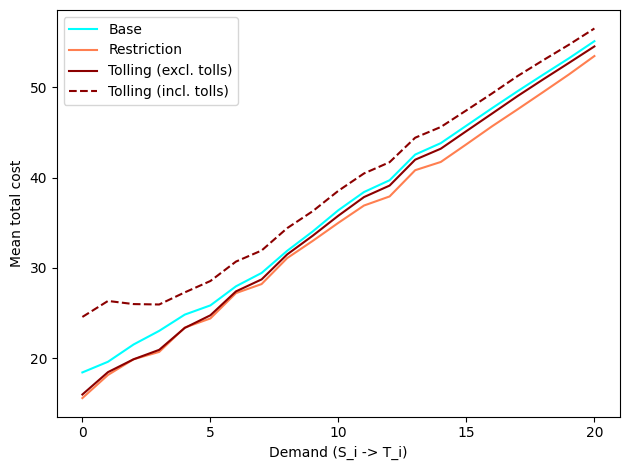

In [559]:
ax = performance.plot(color=[BASE_COLOR, RESTRICTION_COLOR, TOLLING_COLOR, TOLLING_COLOR], style=['-', '-', '-', '--'])
ax.legend()
ax.set_xlabel('Demand (S_i -> T_i)')
ax.set_ylabel('Mean total cost')
ax.xaxis.get_major_locator().set_params(integer=True)
# ax.set_title('Absolute performance')

plt.tight_layout()
ax.get_figure().savefig('braess-result-absolute-performance.pdf', dpi=300, )

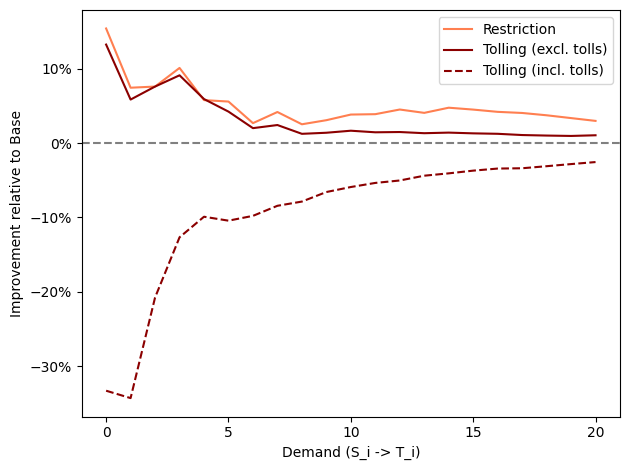

In [560]:
relative_improvement = -(performance.drop('Base', axis=1).sub(performance['Base'], axis=0).div(performance['Base'], axis=0))
ax = relative_improvement.plot(color=[RESTRICTION_COLOR, TOLLING_COLOR, TOLLING_COLOR], style=['-', '-', '--'])
ax.legend()
ax.set_xlabel('Demand (S_i -> T_i)')
ax.set_ylabel('Improvement relative to Base')
ax.axhline(ls='--', color='grey')
ax.xaxis.get_major_locator().set_params(integer=True)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
# ax.set_title('Relative performance')

plt.tight_layout()
ax.get_figure().savefig('braess-result-relative-performance.pdf', dpi=300, )

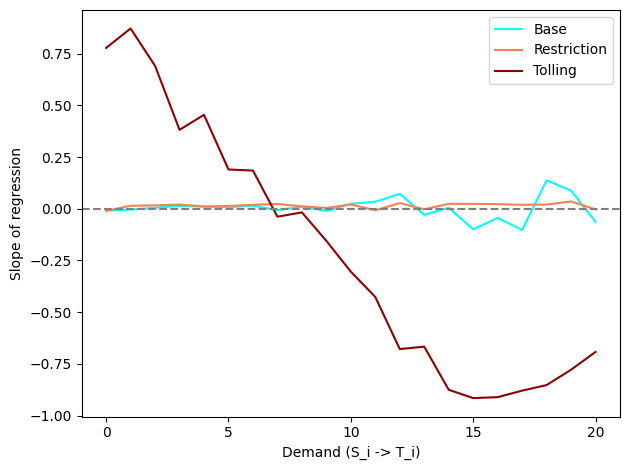

In [561]:
fairness = results['slope'].drop('Tolling (incl. tolls)', axis=1)
fairness.columns = ['Base', 'Restriction', 'Tolling']

ax = fairness.plot(color=[BASE_COLOR, RESTRICTION_COLOR, TOLLING_COLOR])
ax.legend()
ax.set_xlabel('Demand (S_i -> T_i)')
ax.set_ylabel('Slope of regression')
ax.axhline(ls='--', color='grey')
ax.xaxis.get_major_locator().set_params(integer=True)
# ax.set_title('Fairness of treatment')

plt.tight_layout()
ax.get_figure().savefig('braess-result-fairness.pdf', dpi=300, )

In [576]:
{n: (round(x * 80 / 3 - 10), round(10 - y * 80 / 3)) for n, (x, y) in nx.get_node_attributes(create_multiple_braess_network(k=4, capacity=capacity), 'position').items()}

{'S0': (59, -30),
 'A': (59, 50),
 'B': (-10, 10),
 'T0': (30, 10),
 'S1': (-10, -70),
 'S2': (-79, -30),
 'S3': (-79, 50),
 'S4': (-10, 90),
 'T1': (10, -25),
 'T2': (-30, -25),
 'T3': (-50, 10),
 'T4': (-30, 45)}